# Machine Learning Chapter
## Model Evaluation & Validation
## Project: Populations and Weather



>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started
In this project, I will evaluate the performance and predictive power of a model that has been trained and tested on data collected from The Living Planet Index (LPI) and NOAA. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about population fluctuation based on weather behavior. 

The dataset for this project originates from LPI and NOAA. The following preprocessing steps have been made to the dataset:
- populations that occurred in locations with no weather data during the years of the study were removed.
- populations that did not have a weather station within 5 degrees in latitude or longitude were removed.
- All features missing higher than 30% of all measurements across all remaining studies were removed resulting in a total of 16 features. The remainder of the missing data was filled with the average for that location. If no measurements exist for that weather station, the population and corresponding weather data was removed.
- An additional dataset removing all features with more than 20% missing information were removed (resulting in a total of 5 features) and rescaled for possible comparison.
- each study's populations were scaled using MinMaxScaler to an interval [0,1], resulting in all remaining studies with sufficient weather information to be scaled for comparison across studies.
- for both datasets, the scaled population from the previous year is also included as a feature.
- the difference in scaled population was then calculated and will be used as the output.


The following block of code runs all necessary imports for this notebook.

In [1]:
#imports for the Notebook
import numpy as np
import pandas as pd
import sklearn
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.metrics import r2_score as r2, make_scorer
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.model_selection import  GridSearchCV 
# Import supplementary visualizations code visuals.py
import visuals as vs
##from visual.py
import matplotlib.pyplot as pl
from sklearn.model_selection import learning_curve as curves
from sklearn.model_selection import validation_curve as vcurves
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn import tree
from sklearn.ensemble import  RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns


# Pretty display for notebooks
%matplotlib inline
pl.style.use('seaborn-white')

print('import success')

import success


Run the code cell below to load the dataset. You will know the dataset loaded successfully if the size of the dataset is reported. Modifications should be made to the initial values of:
- `dataselect`: options include 70 (for the dataset including all features that are at least 70% reported) and 80 (for the dataset inculding features with at least 80% reporting)
- `analysis_type`: This value determines if analysis is to be performed as a 2 class classification problem (increasing or decreasing population, 'analysis_type' = 0, a multiclass class classification problem (the population changes will be seperated into large increase, small increase, small decrease, and large decrease, where large and small are disinguished by greater than or less than a 0.25 population change, 'analysis_type' = 1), or regression analysis ('analysis_type' = 2)

The output of the cell informs you how many data points are in the dataset, and how many variables are available for each data point. (Note: the number of variables includes other reported information from the study and is not equal to the number of features)

In [8]:
dataselect = 80 #select which dataset, ex: 70 for 70% feature fill or 80 for 80% feature fill
analysis_type = 2 #0 for classification with incr/decr, 1 for multiclass, 2 for regression

# Load the Population dataset
if dataselect == 70:
    data = pd.read_csv('data70.csv')
    data.rename(columns={"lastpop":"Prev. Pop"},inplace=True)
    data.rename(columns={"mmdiff":"Pop Diff"},inplace=True)
    features = data[['TMAX','DP01','DP10','DP1X','DSNW','DT00','DT32','DX70',
               'DX90','EMNT','EMSN','EMXP','EMXT','PRCP','SNOW','TMIN']]
    
if dataselect == 80:
    data = pd.read_csv('data80.csv')
    data.rename(columns={"lastpop":"Prev. Pop"},inplace=True)
    data.rename(columns={"mmdiff":"Pop Diff"},inplace=True)
    features = data[['DP01','DP10','DP1X','EMXP','PRCP']] 

#STRUCTURE DATA FOR CLASSIFICATION OR REGRESSION
if analysis_type == 0:
#   ACTIVATE FOLLOWING ROWS IF INCREASE/DECREASE DESIRED
    data.loc[data['Pop Diff'] <= 0, 'Pop Diff'] = 0
    data.loc[data['Pop Diff'] > 0, 'Pop Diff'] = 1

if analysis_type == 1:
#   ACTIVATE FOLLOWING ROWS IF MULTICLASS DESIRED
    data.loc[data['Pop Diff'] > 0.25, 'Pop Diff'] = 3
    data.loc[(data['Pop Diff'] > 0) & (data['Pop Diff'] <= 0.25), 'Pop Diff'] = 2
    data.loc[(data['Pop Diff'] > -0.25) & (data['Pop Diff'] <= 0), 'Pop Diff'] = 1
    data.loc[data['Pop Diff'] <= -0.25, 'Pop Diff'] = 0

    
# Success
print("The population dataset has {} data points with {} variables each.".format(*data.shape))

Population dataset has 2929 data points with 34 variables each.


## Creating the Test Set
The following cell seperates the population data into test and training datasets, where the `test_data` includes the final year of measured populations for each study, and the remaining years of population data are included into the `train_data`. The cell then seperates the features (inputs) from the label (output, in this case `Pop Diff`). 
Split data into training and test sets. Test sets will be the last year of each study. Traning set will be made of the rest of the years of data.

A dataframe is created for the labels and features of the system. Below, activate the correct columns for the training features (`train_feats`) for the loaded dataset.


In [10]:
test_data = data.sort_values('year').groupby('id').tail(1)
print("The test set contains {} data points.".format(test_data.shape[0]))
# print(data['id'].nunique())
train_data = data.drop(test_data.index)
print("The training set contains {} data points.".format(train_data.shape[0]))

# 80% data initializations
if dataselect == 80:
    test_data = test_data[['id','year','mmscale','Pop Diff','Prev. Pop','DP01','DP10','DP1X','EMXP','PRCP']]
    train_data = train_data[['id','year','mmscale','Pop Diff','Prev. Pop','DP01','DP10','DP1X','EMXP','PRCP']]
    test_labels = test_data[['Pop Diff']]
    test_feats = test_data[['Prev. Pop','DP01','DP10','DP1X','EMXP','PRCP']] #'DP10','DP1X',
    train_labels = train_data[['Pop Diff']]
    train_feats = train_data[['Prev. Pop','DP01','DP10','DP1X','EMXP','PRCP']] 
    tr_feat_label = train_data[['Pop Diff','Prev. Pop','DP01','DP10','DP1X','EMXP','PRCP']]

# 70% data initializations
if dataselect == 70:
    test_data = test_data[['id','year','mmscale','Pop Diff','Prev. Pop','TMAX','DP01','DP10','DP1X','DSNW','DT00','DT32','DX70',
                   'DX90','EMNT','EMSN','EMXP','EMXT','PRCP','SNOW','TMIN']]
    train_data = train_data[['id','year','mmscale','Pop Diff','Prev. Pop','TMAX','DP01','DP10','DP1X','DSNW','DT00','DT32','DX70',
                   'DX90','EMNT','EMSN','EMXP','EMXT','PRCP','SNOW','TMIN']]
    test_labels = test_data[['Pop Diff']]
    test_feats = test_data[['Prev. Pop','TMAX','DP01','DP10','DP1X','DSNW','DT00','DT32','DX70',
                   'DX90','EMNT','EMSN','EMXP','EMXT','PRCP','SNOW','TMIN']]
    train_labels = train_data[['Pop Diff']]
    train_feats = train_data[['Prev. Pop','TMAX','DP01','DP10','DP1X','DSNW','DT00','DT32','DX70',
                   'DX90','EMNT','EMSN','EMXP','EMXT','PRCP','SNOW','TMIN']]
    tr_feat_label = train_data[['Pop Diff','Prev. Pop','TMAX','DP01','DP10','DP1X','DSNW','DT00','DT32','DX70',
                   'DX90','EMNT','EMSN','EMXP','EMXT','PRCP','SNOW','TMIN']]

The test set contains 258 data points.
The training set contains 2671 data points.


## Data Exploration

Before beginning any data exploration, it is important to note that only the training examples will be used for all exploration efforts. Data exploration efforts look at the distribution of population changes in the dataset, a visualization of the correspondences between model features and between each feature and model label (population change), and calculates the correlation between features and between each feature and the label. 

The following cell begins the data exploration efforts by providing a histogram of the population change distribution to ensure that there is a functional distribution of the available data. If using either classification option, The histogram will include a number of columns equal to the number of classes. in the case of preparation for regression, the cell will return a histogram of the bucketed distribution of the population changes.


Text(0.5, 1.0, 'Population Change Distribution - Dataset 1')

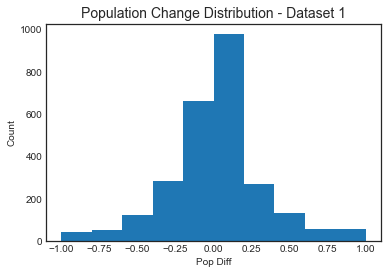

In [11]:
tr_labels_exp = train_labels.copy()

# ACTIVATES IF USING INCR/DECR CLASSES (analysis_type == 0)
if analysis_type == 0:
    tr_labels_exp['lblstring'] = np.where(tr_labels_exp['Pop Diff']==1,'Increase','Decrease')
    tr_labels_exp['lblstring'].value_counts().plot(kind='bar')

# ACTIVATE IF USING MULTICLASS (analysis_type == 1)
if analysis_type == 1:
    tr_labels_exp.loc[data['Pop Diff'] == 0, 'lblstring'] = 'Large Decrease'
    tr_labels_exp.loc[data['Pop Diff'] == 1, 'lblstring'] = 'Small Decrease'
    tr_labels_exp.loc[data['Pop Diff'] == 2, 'lblstring'] = 'Small Increase'
    tr_labels_exp.loc[data['Pop Diff'] == 3, 'lblstring'] = 'Large Increase'
    tr_labels_exp['lblstring'].value_counts().reindex(['Large Decrease', 'Small Decrease',
                                                   'Small Increase', 'Large Increase']).plot(kind='bar')
#hist, bin_edges = np.histogram(train_labels['Pop Diff'].values)
pl.hist(train_labels['Pop Diff'].values)
pl.xticks(rotation=0)
pl.xlabel('Pop Diff')
pl.ylabel('Count')
pl.title('Population Change Distribution - Dataset 1', fontsize = 14)
#pl.savefig('PopChangeHist80_2class.png')
#hist

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the weather features present in the data. This will graphically/visually demonstrate correlations between different features. The diagonal plots are a kde, defined according to the support literature for the pdandas function as "In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the probability density function (PDF) of a random variable. This function uses Gaussian kernels and includes automatic bandwidth determination"  

This cell returns a scatter matrix comprised of scatter plots for each feature (and the population difference) against each of the other feature. It should be noted that the distributions of `Pop Diff` and `Prev. Pop` are quite odd in the case of regression preparation. This is an artifact of the scaling behavior, demonstrating some constraints of the scaling process. To understand this, imagine the scenario in which the population is the highest measurement of the available data in that study. Because of the scaling, this population value will be scaled to 1, ensuring that the population change can only be a decrease. The opposite effect occurs for the lowest population of the study, scaling to 0. While this does not hinder progression of the model, it is absolutely necessary to consider this moving forward and the impacts this may have. 

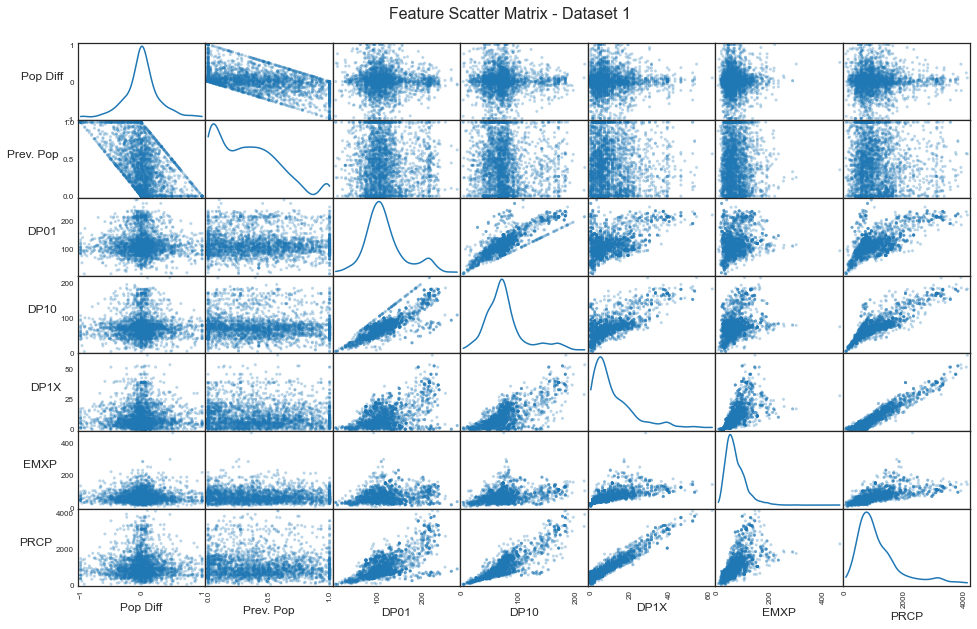

In [12]:
# tr_feat_label.rename(columns={"Prev. Pop":"Prev. Pop"},inplace=True)
# tr_feat_label.rename(columns={"Pop Diff": "Pop Diff"},inplace=True)

# Produce a scatter matrix for each pair of features in the data
axes = pd.plotting.scatter_matrix(tr_feat_label, alpha = 0.3, figsize = (16,10), diagonal = 'kde');
#pl.ylabel('Count',rotation=45)

for ax in axes.flatten():
#     ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(0)
    ax.xaxis.label.set_va('top')
    ax.yaxis.label.set_ha('right')
#     ax.yaxis.label.set_va('bottom')
    ax.xaxis.label.set_fontsize(12)
    ax.yaxis.label.set_fontsize(12)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    for tick in ax.get_yticklabels():
        tick.set_rotation(0)

if dataselect == 80: 
    pl.suptitle('Feature Scatter Matrix - Dataset 1',fontsize = 16, y = 0.93)
#     pl.savefig('FeatScatMat80_Final.png')

if dataselect == 70: 
    pl.suptitle('Feature Scatter Matrix - Dataset 2',fontsize = 16, y = 0.93)
#     pl.savefig('FeatScatMat70_Final.png')

## Correlations
The next cell creates a correlation heatmap, presenting the measured correlations that are shown vissually by the scatter matrix above. While some models may have little impact from the inclusion of correlated features, it is common practice to remove them where possible. 

This visualization also allows for the comparison of the training label and each of the features, which can be telling of possible avenues for analysis. For instance, if there were a situation with a high correlation between the label and one or two features, traditional analyitical practices are likely to be successful. In the case of population changes and available weather attributes, there is nearly zero correlation between `Pop Diff` and any of the features except `Prev. Pop`, and even then, the correlation with the label is low. For this reason, traditional analytics are likely not the best path forward. 

,Pop Diff,Prev. Pop,DP01,DP10,DP1X,EMXP,PRCP
count,2671.000000,2671.000000,2671.000000,2671.000000,2671.000000,2671.000000,2671.000000
mean,0.011537,0.413631,117.092078,75.093874,10.569676,69.828596,1076.403731
std,0.318454,0.311129,43.639457,33.972509,9.730779,37.786549,676.850021
min,-1.000000,0.000000,8.000000,3.000000,0.000000,4.800000,45.500000
25%,-0.129032,0.135135,90.000000,54.000000,4.000000,43.400000,621.600000
50%,0.000000,0.380753,108.000000,70.000000,7.000000,61.277778,904.100000
75%,0.143824,0.641193,133.000000,84.000000,15.000000,88.000000,1359.150000
max,1.000000,1.000000,277.000000,216.000000,62.000000,464.800000,4121.500000


           Pop Diff  Prev. Pop      DP01      DP10      DP1X      EMXP  \
Pop Diff   1.000000  -0.512355 -0.008980 -0.006887  0.002524  0.013869   
Prev. Pop -0.512355   1.000000 -0.002177 -0.035452 -0.029019 -0.025969   
DP01      -0.008980  -0.002177  1.000000  0.833304  0.535531  0.225005   
DP10      -0.006887  -0.035452  0.833304  1.000000  0.751799  0.373370   
DP1X       0.002524  -0.029019  0.535531  0.751799  1.000000  0.644019   
EMXP       0.013869  -0.025969  0.225005  0.373370  0.644019  1.000000   
PRCP       0.003329  -0.032411  0.683550  0.873257  0.957750  0.628252   

               PRCP  
Pop Diff   0.003329  
Prev. Pop -0.032411  
DP01       0.683550  
DP10       0.873257  
DP1X       0.957750  
EMXP       0.628252  
PRCP       1.000000  


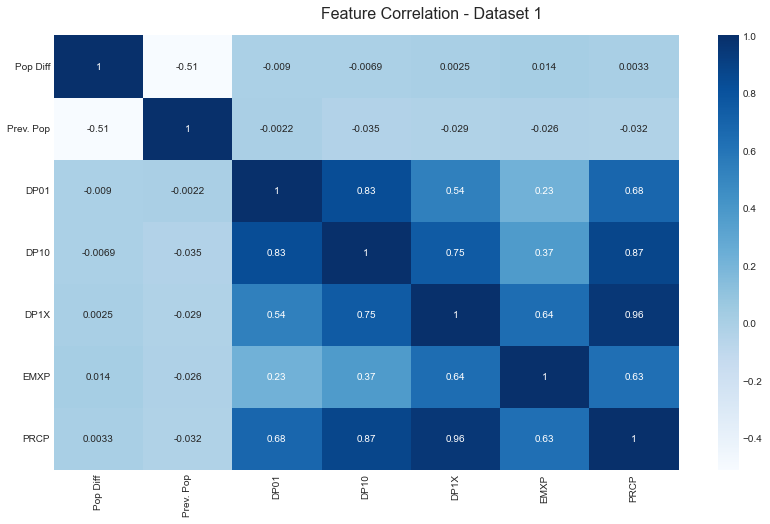

In [13]:
display(tr_feat_label.describe())

pl.figure(figsize=(14,8))
sns.heatmap(tr_feat_label.corr(),annot=True,cmap = 'Blues')
if dataselect == 80:
    pl.suptitle('Feature Correlation - Dataset 1',fontsize = 16, y = 0.93)
    pl.yticks(rotation=0)
    pl.xticks(rotation=90)
#     pl.savefig('CorrelationHeatmap80_Final.png', bbox_inches='tight')
if dataselect == 70:
    pl.suptitle('Feature Correlation - Dataset 2',fontsize = 16, y = 0.93)
    pl.yticks(rotation=0)
    pl.xticks(rotation=90)
#     pl.savefig('CorrelationHeatmap70_Final.png', bbox_inches='tight')

corr = tr_feat_label.corr()

### Correlation Removal

Because of the small number of available features, the threshold for removing highly correlated features was set at 90% correlation. In the case that a correlation above 90% occurred, a check is done it see if one of the features has multiple high correlation values. In the case that the removal of one feature can remove multiple high correlation values, that feature is removed. Otherwise, one of the correlated features was removed without preference. These removals have been done "by hand," but will be automated in the future.

## ***must add correlation removal to notebook here***

In [ ]:
# place holder for correlation removal. Possibly use corr values to determine correlation removal. 
# this cell should also include some output listing the final included features. 

----

## Developing a Model
The following function gives a look into the performance of different models. 

This code block is structured to "toggle" between different types of estimators. Activate the desired estimator by uncommenting the line of the selected estimator, ensuring that all others are commented out.

Once an estimator is selected, Feed in the features of the system as 'X' and the labels as 'y'. The function will create `n_splits`=10 different cross-validation training and validation sets from the training data given to the function. The function outputs the `score` averaged over the 10 cross-validation sets, with transparent fill demonstrating standard deviation. For regression estimators, `score` = 'r2' for an R^2 score, and for classification estimators `score` = 'mse' for mean squared error.

The function calculates scores for a range of `train_sizes` from 100 data points to the maximum possible number of data points in equally spaced intervals resulting in 9 different train sizes. When the estimator is a Decision Tree (regression of classification), the function will calculate scores for multiple tree depths.

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

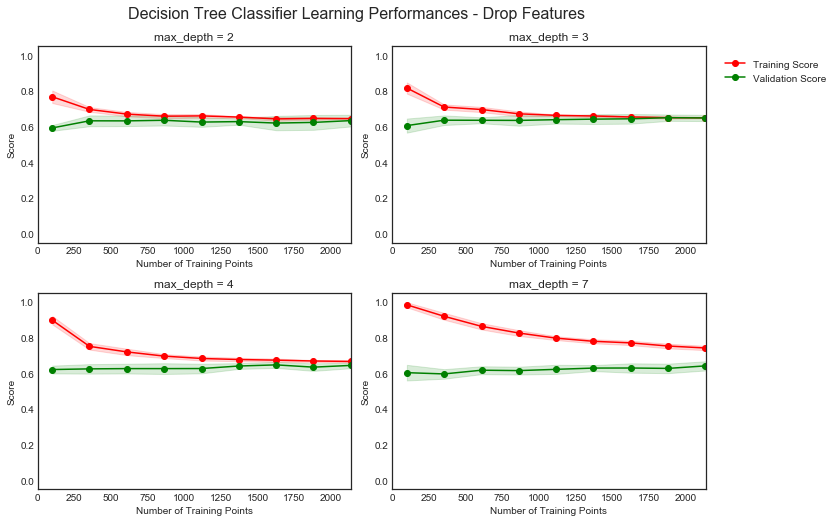

In [49]:
def ModelLearning(X, y):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and testing scores for each model are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.1, random_state = None)

    # Generate the training set sizes increasing by uniform interval
    train_sizes = np.rint(np.linspace(100, X.shape[0]*0.8 - 1, 9)).astype(int)

    # Create the figure window
    fig = pl.figure(figsize=(10,7))

    # Create three different models based on max_depth
    for k, depth in enumerate([2, 3, 4, 7]):
        
        # Create a Decision tree regressor at max_depth = depth
        #estimator = DecisionTreeRegressor(max_depth = depth) #,criterion='friedman_mse',max_features=3,min_samples_split=.1,min_samples_leaf=.05
        #estimator = RandomForestRegressor(n_estimators=100, criterion='mse', verbose=1,max_depth=depth, min_samples_split=.1, min_samples_leaf=.1)
        #estimator = LinearRegression(fit_intercept=False)
        #estimator = svm.SVR(verbose=10)
        #ABOVE REGRESSION, BELOW CLASSIFIERS
        #estimator = svm.SVC(verbose=10)
        #estimator = svm.LinearSVC(verbose=10)
        #estimator = LogisticRegression()
        #estimator = LinearDiscriminantAnalysis()
        #estimator = KNeighborsClassifier()
        #estimator = GaussianNB()
        #estimator = DecisionTreeClassifier(max_depth = depth)#max_features=3,min_samples_split=.1,min_samples_leaf=.05,
        estimator = RandomForestClassifier(max_depth=depth, n_estimators=50)
        # Calculate the training and testing scores
        sizes, train_scores, test_scores = curves(estimator, X, y, \
            cv = cv, train_sizes = train_sizes, scoring = 'accuracy',shuffle=True)
        
        # Find the mean and standard deviation for smoothing
        train_std = np.std(train_scores, axis = 1)
        train_mean = np.mean(train_scores, axis = 1)
        test_std = np.std(test_scores, axis = 1)
        test_mean = np.mean(test_scores, axis = 1)

        # Subplot the learning curve 
        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
        ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Validation Score')
        ax.fill_between(sizes, train_mean - train_std, \
            train_mean + train_std, alpha = 0.15, color = 'r')
        ax.fill_between(sizes, test_mean - test_std, \
            test_mean + test_std, alpha = 0.15, color = 'g')
        
        # Labels
        ax.set_title('max_depth = %s'%(depth))
        ax.set_xlabel('Number of Training Points')
        ax.set_ylabel('Score')
        ax.set_xlim([0, X.shape[0]*0.8])
        ax.set_ylim([-0.05, 1.05])
    
    # Visual aesthetics
    ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Decision Tree Classifier Learning Performances - Drop Features', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()
    
    return estimator
    
    
estimator=ModelLearning(train_feats, train_labels)

# pl.savefig('ModelLearnDecTreeClass80_2class_dropboth.png', bbox_inches='tight')

## Training the Model

Once exploration has been completed and highly correlated features have been removed, and multiple ML algorithms have been tested, three models were selected for analysis. Below find the results for:
- Decision Tree Classifier (DTC)
- Random Forest Classifier (FR)
- Linear Regression (LR)

Each of these models is first examined using default hyperparameters (a hyperparameter is a value that dictates the model training behavior and have no connection to the data.)  All model training and corresponding results will be marked with a title starting with **Untuned**. Following the results of model fitment with default hyper parameters, in the case of classification (DTC and RF), a maximum tree depth (`max_depth`) was set at 3 to prevent overfitting.  Finally, for all three models, a GridSearch is run on the tunable hyperparameters in an effort to optimize model performance.  These three models for classification (Untuned, max_depth=3, and Tuned) and two models for LR (Untuned, Tuned) were compared to determine which model was most effective and to invesigate the impact of tuning the availabe hyperparameters.

 #### Feature Importances
`feature_importances` gives insight into the importance of each feature in the trained model. In the case that one feature has an importance near 1, then the predictive model is relying almost entirely on that one feature. Generally, it is desireable to have the feature importance spread across the features instead of all on one feature.
#### Model Score
Passing the test set (which is comprised of the final population of each included study, as created near the beginning of this notebook) into `model.score` results in an accuracy score of model prediction based on the test data.

#### Untuned Decision Tree Classifier

In [118]:
DTCog = DecisionTreeClassifier(random_state=42)
DTCog.fit(train_feats, train_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [119]:
DTCog.feature_importances_

array([ 0.42542461,  0.17107902,  0.19823874,  0.20525763])

In [120]:
DTCog.score(test_feats,test_labels)

0.52713178294573648

#### Decision Classifier with max_depth=3

In [121]:
DTC3 = DecisionTreeClassifier(max_depth=3,random_state=42)
DTC3.fit(train_feats, train_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [122]:
DTC3.feature_importances_

array([ 0.94945862,  0.        ,  0.02128836,  0.02925302])

In [123]:
DTC3.score(test_feats,test_labels)

0.54651162790697672

#### Untuned Random Forest Classifier

In [124]:
rf = RandomForestClassifier(random_state=42)
rf.fit(train_feats, train_labels)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [125]:
rf.feature_importances_

array([ 0.427174  ,  0.18611195,  0.19286435,  0.1938497 ])

In [126]:
rf.score(test_feats,test_labels)

0.55813953488372092

#### Random Forest with max_depth=3

In [152]:
rf3 = RandomForestClassifier(max_depth=3,random_state=42)
rf3.fit(train_feats, train_labels)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [153]:
rf3.feature_importances_

array([ 0.74603854,  0.07046087,  0.11680027,  0.06670032])

In [154]:
rf3.score(test_feats,test_labels)

0.55426356589147285

## Grid Search
Grid search is a function to assist with tuning paramters of the model. For instance `max_depth` = 3 limits the algorithm such that it can have a total of 3 levels of branching. Hyperparameter tuning can assist in a better model, but can also cause issues like over fitting.

### Decision Tree Classifier - Grid Search

In [162]:
max_depth = np.arange(1,7)
min_samp_split = np.arange(2,51)
min_samp_leaf = np.arange(1,51)
max_feats = np.arange(1,5)

In [163]:
param_gridDTC = {'max_depth': max_depth, 
              'min_samples_split': min_samp_split,
              'min_samples_leaf': min_samp_leaf,
              'max_features': max_feats}
gssearchDTC = gs.GridSearchCV(DecisionTreeClassifier(random_state=42), param_gridDTC)
gssearchDTC.fit(train_feats,train_labels['Pop Diff'].values)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6]), 'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]), 'min_sam..., 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]), 'max_features': array([1, 2, 3, 4])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [164]:
DTCfitparams = gssearchDTC.best_params_
print(DTCfitparams)

{'max_depth': 2, 'max_features': 3, 'min_samples_leaf': 30, 'min_samples_split': 2}


In [165]:
DTC = DecisionTreeClassifier(max_depth=2, max_features=3, min_samples_leaf=30, min_samples_split=2,random_state=42)
DTC.fit(train_feats, train_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=30,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [166]:
DTC.feature_importances_

array([ 0.96450425,  0.        ,  0.        ,  0.03549575])

In [167]:
DTC.score(test_feats,test_labels)

0.55426356589147285

#### Random Forest Classifier - Grid Search

In [170]:
max_depthRF = np.arange(1,8)
n_estimatorsRF = [50,100,150,200]
min_samp_splitRF = np.arange(2,51,5)
min_samp_leafRF = np.arange(1,51,5)
max_featsRF = np.arange(1,5)

In [171]:
param_gridRFC = {'max_depth': max_depthRF, 
              'min_samples_split': min_samp_splitRF,
              'min_samples_leaf': min_samp_leafRF,
              'max_features': max_featsRF,
              'n_estimators': n_estimatorsRF,
              'criterion':('gini', 'entropy')}
gssearchRFC = gs.GridSearchCV(RandomForestClassifier(random_state=42), param_gridRFC)
gssearchRFC.fit(train_feats,train_labels['Pop Diff'].values)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7]), 'min_samples_split': array([ 2,  7, 12, 17, 22, 27, 32, 37, 42, 47]), 'min_samples_leaf': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46]), 'max_features': array([1, 2, 3, 4]), 'n_estimators': [50, 100, 150, 200], 'criterion': ('gini', 'entropy')},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [172]:
RFCfitparams = gssearchRFC.best_params_
print(RFCfitparams)

{'criterion': 'gini', 'max_depth': 2, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [173]:
RFC = RandomForestClassifier(criterion='gini',max_depth=2, max_features=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42)
RFC.fit(train_feats, train_labels)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [174]:
RFC.feature_importances_

array([ 0.92565802,  0.01266165,  0.03673021,  0.02495013])

In [138]:
RFC.score(test_feats,test_labels)

0.53488372093023251

### Model Performance Visualization

The following cell is used to visualize model fitment by plotting the training and validation curves of a selected model against the score (score is accuracy for classification and r2 for regression).  These curves provide a visual check for model overfitment, or the situation a model fits very well for the training set, but the model does not predict validation/test data to the same score. This indicates that the model has fit to specifically to the training data and is not generalized enough for accurately predicting outcomes for new data.

## ***The following cell needs to be updated to take in `analysis_type` and output the correct outcome based on the analysis_type input***

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

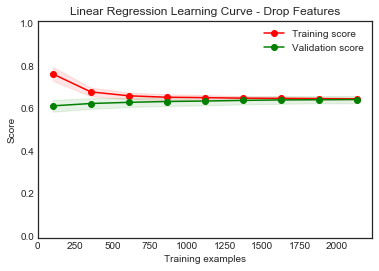

In [175]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
#     if axes is None:
#         _, axes = plt.subplots(1, 2, figsize=(20, 5))

    pl.title(title)
    if ylim is not None:
        pl.ylim(*ylim)
    pl.xlabel("Training examples")
    pl.ylabel("Score")

#     train_sizes, train_scores, test_scores, fit_times, _ = \
#         learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
#                        train_sizes=train_sizes)#,
#                        #return_times=True)
    sizes, train_scores, test_scores = curves(estimator, X, y, \
                                               cv=cv, train_sizes=train_sizes, scoring='accuracy', shuffle=True)
#       sizes, train_scores, test_scores = curves(estimator, X, y, \
#                                         cv=cv, train_sizes=train_sizes, scoring ='r2',shuffle=True)


    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
#     fit_times_mean = np.mean(fit_times, axis=1)
#     fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
#     axes[0].grid()
    pl.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    pl.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    pl.plot(train_sizes, train_scores_mean, 'o-', color="r",
                         label="Training score")
    pl.plot(train_sizes, test_scores_mean, 'o-', color="g",
                         label="Validation score")
    pl.legend(loc="best")

    return pl



title = "Linear Regression Learning Curve - Drop Features"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
# estimator = DecisionTreeClassifier(max_depth=3,random_state=42)# 
# estimator = RandomForestClassifier(max_depth=3,random_state=42)# max_depth=3,
# estimator = DecisionTreeClassifier(max_depth=2, max_features=3, min_samples_leaf=30, min_samples_split=2,random_state=42)
estimator = RandomForestClassifier(criterion='gini',max_depth=2, max_features=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42)
X = train_feats
y = train_labels
train_sizes = np.rint(np.linspace(100, X.shape[0]*0.8 - 1, 9)).astype(int)
plot_learning_curve(estimator, title, X, y,axes=None, train_sizes=train_sizes, ylim=(-0.01, 1.01),
                            cv=cv, n_jobs=1)#


# pl.savefig('RFCTunedLearningCurve.png')
pl.show()

#### ROC (only for 2 class system)
Reciever Operator Characteristics

ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

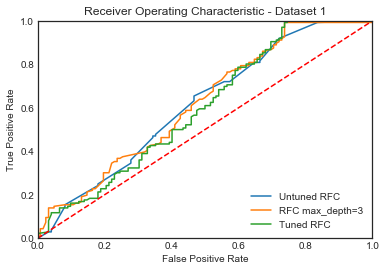

In [177]:
if analysis_type == 0:
    # calculate the fpr and tpr for all thresholds of the classification
    probsDTCog = DTCog.predict_proba(test_feats)
    probsrf = rf.predict_proba(test_feats)
    probsDTC3 = DTC3.predict_proba(test_feats)
    probsrf3 = rf3.predict_proba(test_feats)
    probsDTC = DTC.predict_proba(test_feats)
    probsRFC = RFC.predict_proba(test_feats)

    predsDTCog = probsDTCog[:,1]
    predsrf = probsrf[:,1]
    predsDTC3 = probsDTC3[:,1]
    predsrf3 = probsrf3[:,1]
    predsDTC = probsDTC[:,1]
    predsRFC = probsRFC[:,1]

    fprDTCog, tprDTCog, threshold = metrics.roc_curve(test_labels, predsDTCog)
    fprrf, tprrf, threshold = metrics.roc_curve(test_labels, predsrf)
    fprDTC3, tprDTC3, threshold = metrics.roc_curve(test_labels, predsDTC3)
    fprrf3, tprrf3, threshold = metrics.roc_curve(test_labels, predsrf3)
    fprDTC, tprDTC, threshold = metrics.roc_curve(test_labels, predsDTC)
    fprRFC, tprRFC, threshold = metrics.roc_curve(test_labels, predsRFC)

    roc_auc_DTCog = metrics.auc(fprDTCog, tprDTCog)
    roc_auc_rf = metrics.auc(fprrf, tprrf)
    roc_auc_DTC3 = metrics.auc(fprDTC3, tprDTC3)
    roc_auc_rf3 = metrics.auc(fprrf3, tprrf3)
    roc_auc_DTC = metrics.auc(fprDTC, tprDTC)
    roc_auc_RFC = metrics.auc(fprRFC, tprRFC)


    pl.title('Receiver Operating Characteristic - Dataset 1')
    # pl.plot(fprDTCog, tprDTCog, label = 'Untuned DTC' % roc_auc_DTCog)
    pl.plot(fprrf, tprrf, label = 'Untuned RFC' % roc_auc_rf)
    # pl.plot(fprDTC3, tprDTC3, label = 'DTC max_depth=3' % roc_auc_DTC3)
    pl.plot(fprrf3, tprrf3, label = 'RFC max_depth=3' % roc_auc_rf3)
    # pl.plot(fprDTC, tprDTC, label = 'Tuned DTC' % roc_auc_DTC)
    pl.plot(fprRFC, tprRFC, label = 'Tuned RFC' % roc_auc_RFC)
    pl.legend(loc = 'lower right')
    pl.plot([0, 1], [0, 1],'r--')
    pl.xlim([0, 1])
    pl.ylim([0, 1])
    pl.ylabel('True Positive Rate')
    pl.xlabel('False Positive Rate')
#     pl.savefig('ROC80_2class_RFC.png', bbox_inches='tight')
    pl.show()

#### Confusion Matrix (primarily for Multiclass configuration of data)
Confusion matrices are used to evaluate the quality of the output of a classifier on the data set. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

The confusion matrix can also provide insight into what the model predicts, and if it seems to have bias. for instance, if one column is continually higher than the others, the model is predicting that result more frequently than any other.

[[1334   33]
 [  53 1251]]


([<matplotlib.axis.YTick at 0x1a17b3ce80>,
 <a list of 2 Text yticklabel objects>)

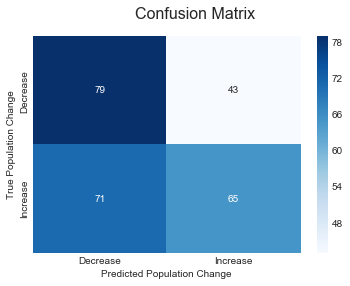

In [63]:

test_pred = rf.predict(test_feats)
train_pred = rf.predict(train_feats)
cf_mat = metrics.confusion_matrix(test_labels,test_pred)
cf_mat2 = metrics.confusion_matrix(train_labels,train_pred)
print(cf_mat2)
sns.heatmap(cf_mat, annot=True, cmap='Blues')
pl.suptitle('Confusion Matrix',fontsize = 16,)# y = 0.93)
pl.xlabel('Predicted Population Change')
pl.ylabel('True Population Change')

# pl.xticks(np.arange(4)+0.5,['Large Decrease', 'Small Decrease', 'Small Increase','Large Increase'], rotation=35)
# pl.yticks(np.arange(4)+0.35,['Large Decrease', 'Small Decrease', 'Small Increase','Large Increase'], rotation=35)

pl.xticks(np.arange(2)+0.5,['Decrease','Increase'])
pl.yticks(np.arange(2)+0.35,['Decrease','Increase'])

#pl.savefig('DecTreeClassConfMatHeatMap80Multiclass.png', bbox_inches='tight')

## Regression Model
#### Untuned Linear Regression

In [103]:
LR = LinearRegression() #fit_intercept=False
LR.fit(train_feats, train_labels) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [104]:
LR.coef_

array([[ -5.26286413e-01,   2.49480721e-04,  -1.07782719e-03,
         -2.04183780e-03,  -2.26729557e-05,   5.88821155e-05]])

In [105]:
LR.score(test_feats,test_labels)

0.19831940707792206

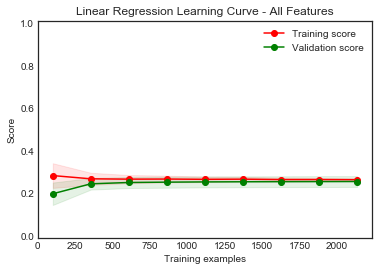

In [7]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    See desciptions of tuning parameters above
    """
#     if axes is None:
#         _, axes = plt.subplots(1, 2, figsize=(20, 5))

    pl.title(title)
    if ylim is not None:
        pl.ylim(*ylim)
    pl.xlabel("Training examples")
    pl.ylabel("Score")

#     train_sizes, train_scores, test_scores, fit_times, _ = \
#         learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
#                        train_sizes=train_sizes)#,
#                        #return_times=True)
    sizes, train_scores, test_scores = curves(estimator, X, y, \
                                               cv=cv, train_sizes=train_sizes, scoring='r2', shuffle=True)
#       sizes, train_scores, test_scores = curves(estimator, X, y, \
#                                         cv=cv, train_sizes=train_sizes, scoring ='r2',shuffle=True)


    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
#     fit_times_mean = np.mean(fit_times, axis=1)
#     fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
#     axes[0].grid()
    pl.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    pl.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    pl.plot(train_sizes, train_scores_mean, 'o-', color="r",
                         label="Training score")
    pl.plot(train_sizes, test_scores_mean, 'o-', color="g",
                         label="Validation score")
    pl.legend(loc="best")

    return pl



title = "Linear Regression Learning Curve - All Features"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = LinearRegression()
X = train_feats
y = train_labels
train_sizes = np.rint(np.linspace(100, X.shape[0]*0.8 - 1, 9)).astype(int)
plot_learning_curve(estimator, title, X, y,axes=None, train_sizes=train_sizes, ylim=(-0.01, 1.01),
                            cv=cv, n_jobs=1)#


# pl.savefig('LR80LearnCurve_All_Features.png')
pl.show()

#### Linear Regression - Grid Search

In [26]:
fit_intercept = [True, False]
normalize = [True, False]

In [28]:
param_gridLR = {'fit_intercept': fit_intercept, 
              'normalize': normalize}
gssearchLR = gs.GridSearchCV(LinearRegression(), param_gridLR)
gssearchLR.fit(train_feats,train_labels['Pop Diff'].values)

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'fit_intercept': [True, False], 'normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [30]:
LRfitparams = gssearchLR.best_params_
print(LRfitparams)

{'fit_intercept': True, 'normalize': True}


In [111]:
LR = LinearRegression(fit_intercept=True, normalize=True)
LR.fit(train_feats, train_labels) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [112]:
LR.coef_

array([[ -5.24853377e-01,   3.13944585e-05,   1.36184723e-04,
         -1.24130027e-05]])

In [113]:
LR.score(test_feats,test_labels)

0.19786924179540655